In [1]:
!kaggle datasets download zhangluyuan/ab-testing

Dataset URL: https://www.kaggle.com/datasets/zhangluyuan/ab-testing
License(s): unknown
 99%|█████████████████████████████████████▋| 4.00M/4.04M [00:01<00:00, 3.81MB/s]
100%|██████████████████████████████████████| 4.04M/4.04M [00:01<00:00, 2.80MB/s]


In [2]:
!unzip ab-testing.zip

Archive:  ab-testing.zip
  inflating: ab_data.csv             


# **Imports**

Before we start, I would like to say *Thank you* to the author of [this](https://github.com/renatofillinich/ab_test_guide_in_python/blob/master/AB%20testing%20with%20Python.ipynb) notebook!

In [108]:
import numpy as np
import statsmodels.stats.api as sms
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import sweetviz as sv

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# **Downloading and exploring the data**

In [98]:
df = pd.read_csv('ab_data.csv')

df.sample(3)

,user_id,timestamp,group,landing_page,converted
187007,925478,2017-01-12 12:54:15.058771,control,old_page,0
265750,891435,2017-01-18 04:50:08.288879,control,new_page,1
250115,934860,2017-01-21 16:29:17.541564,treatment,new_page,0


                                             |                                                                …


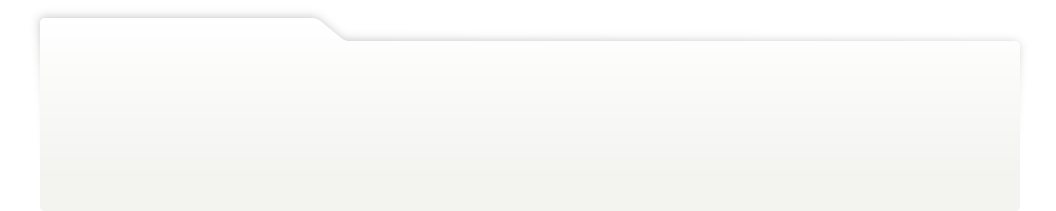
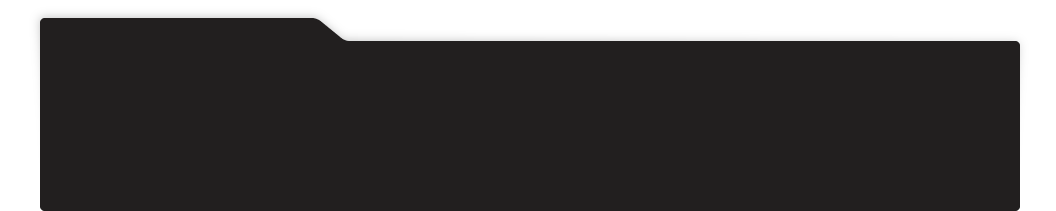
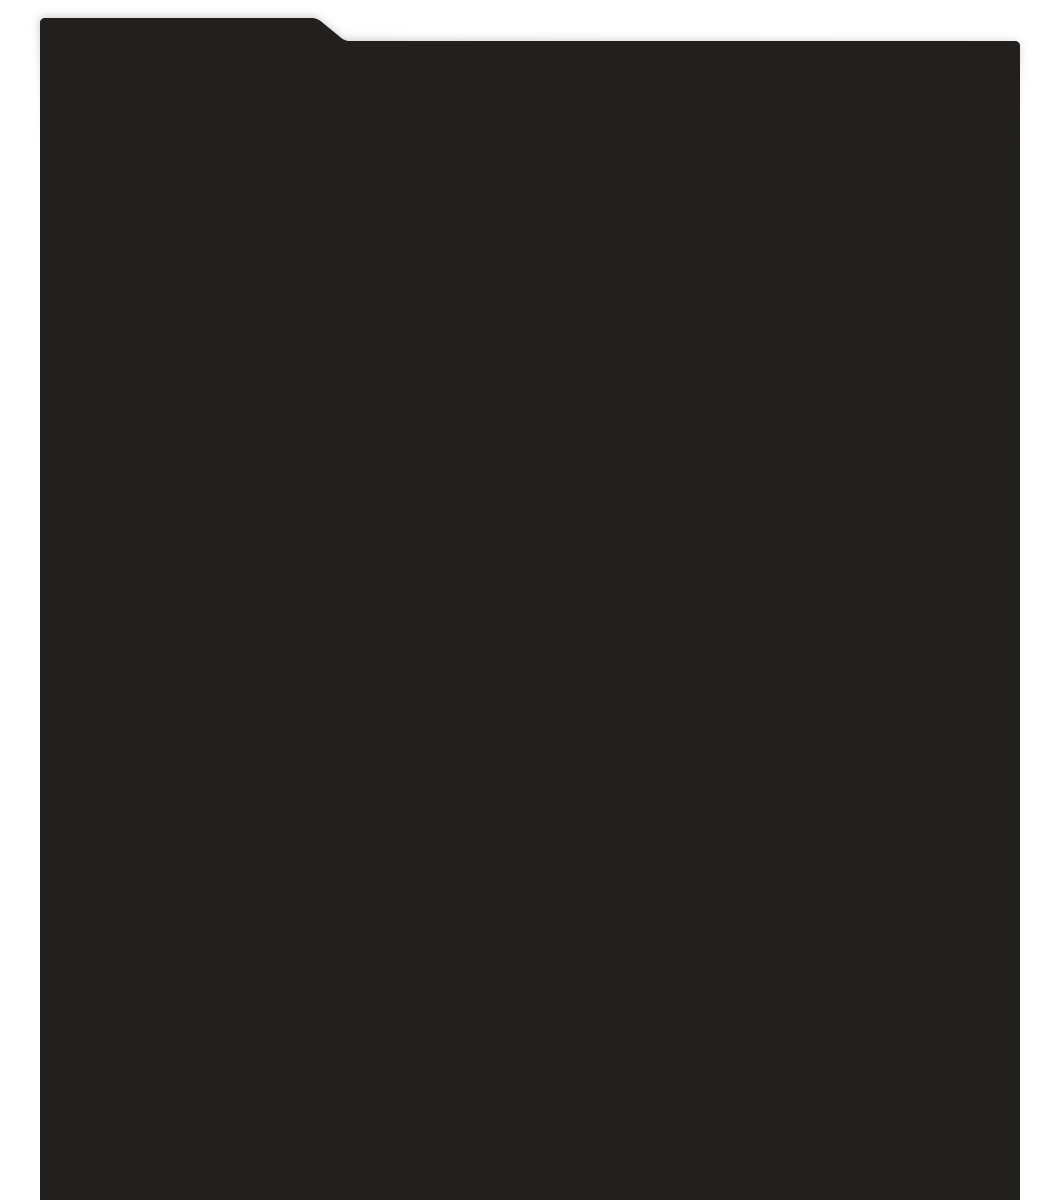
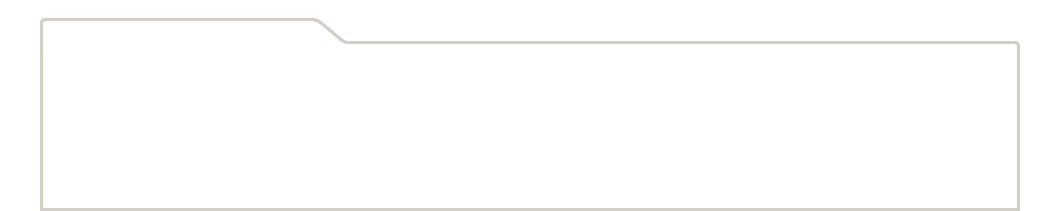
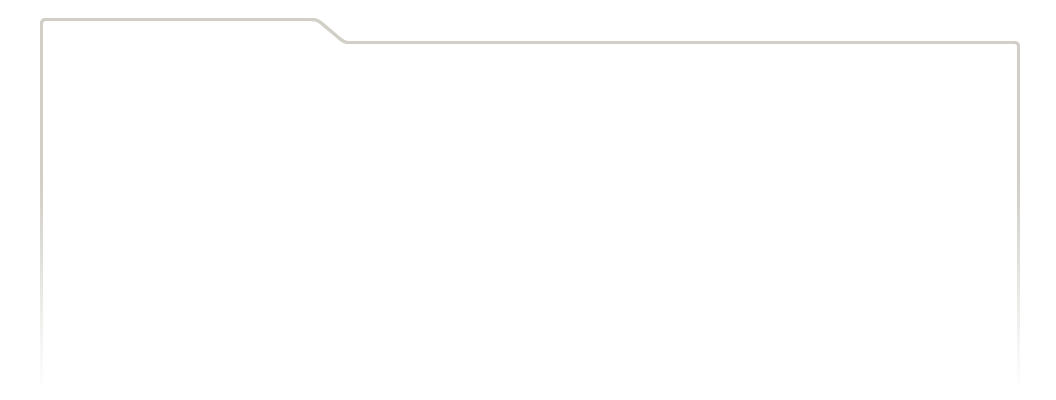
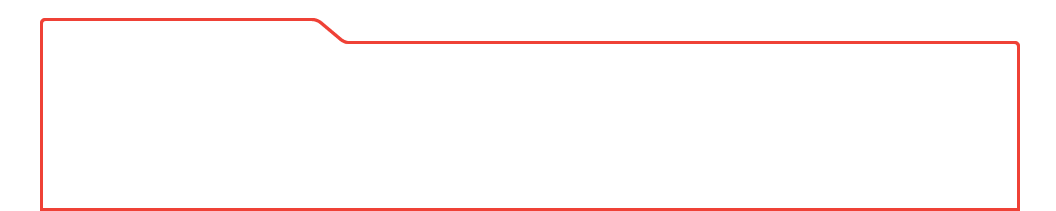
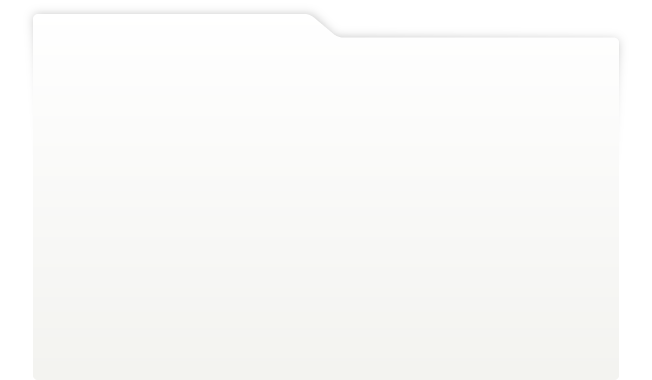
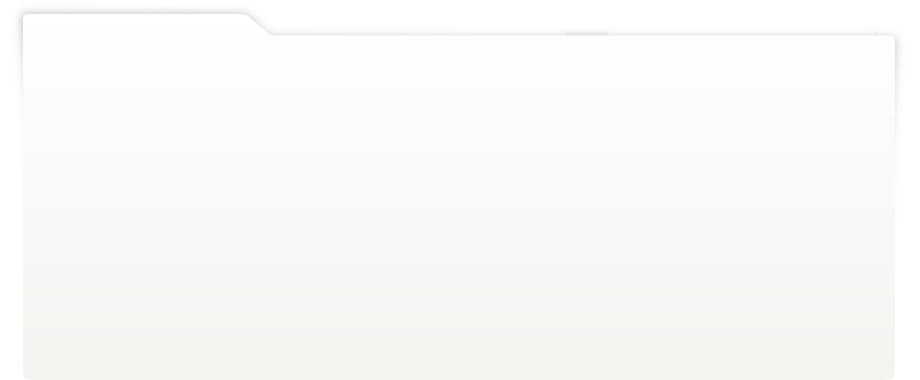
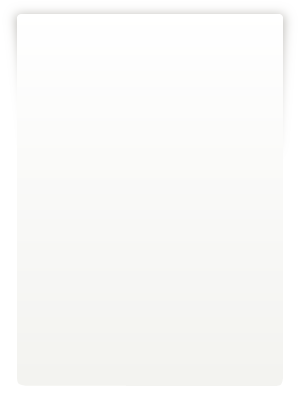
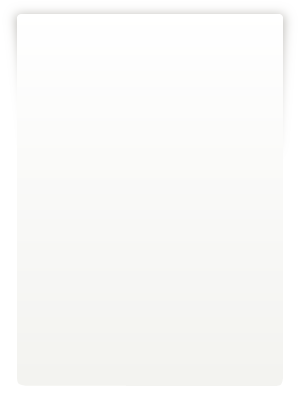
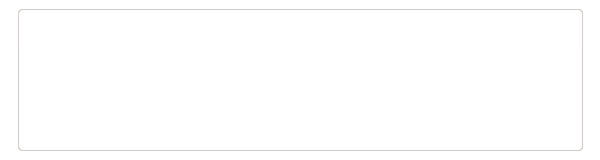
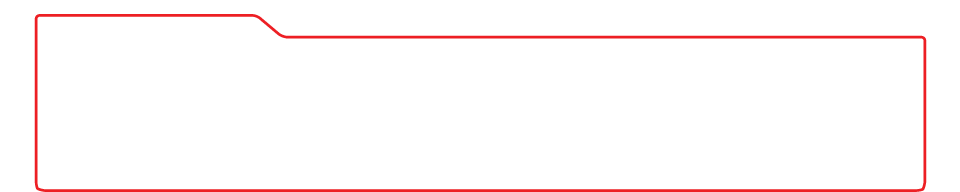
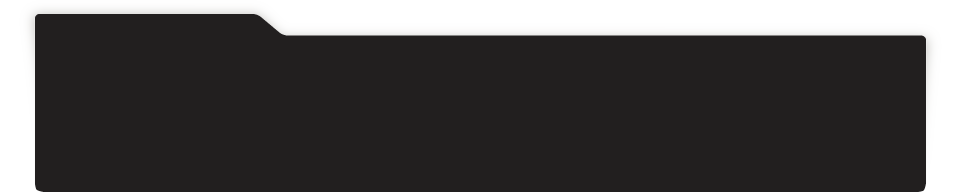
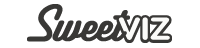
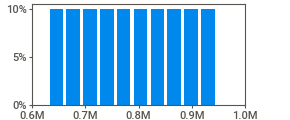
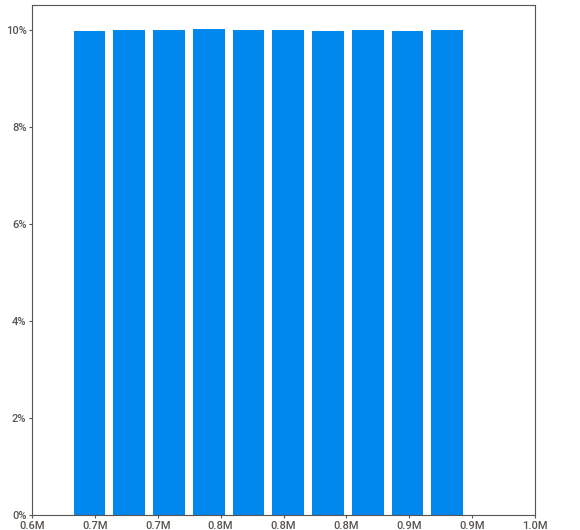
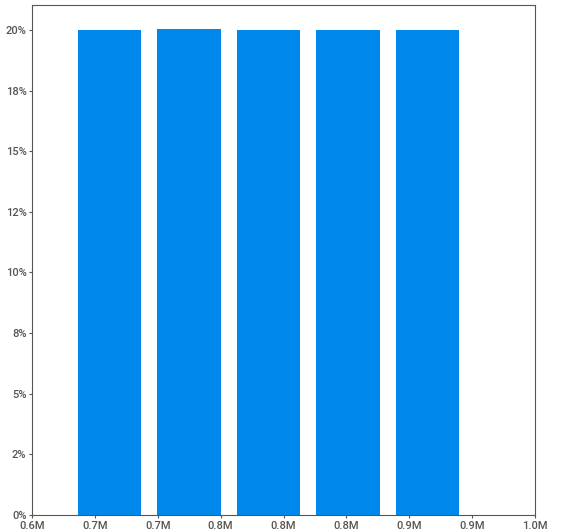
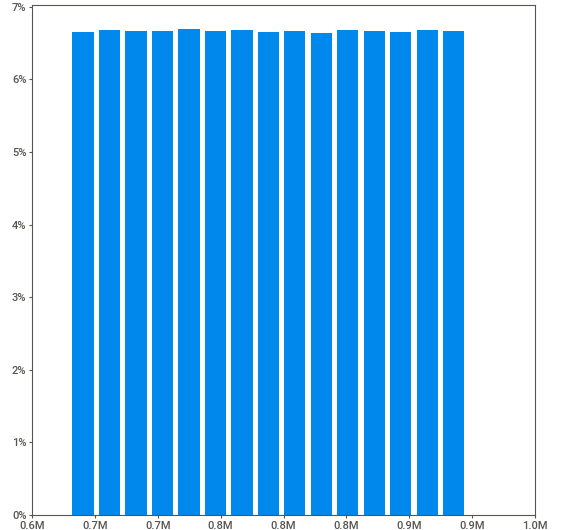
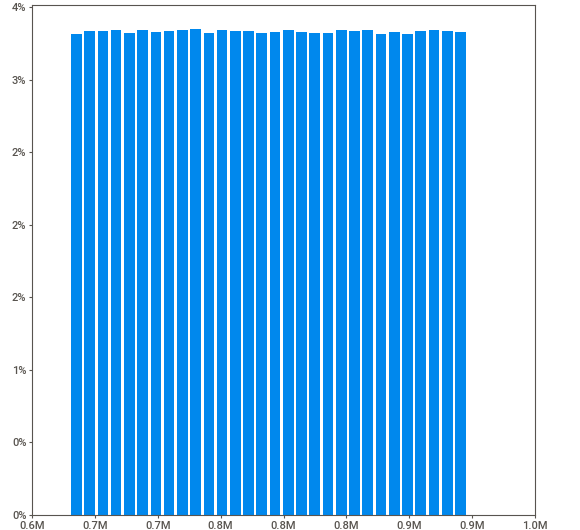
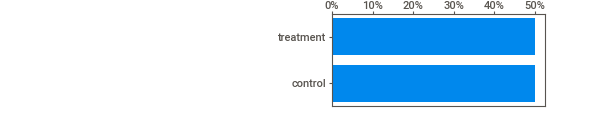
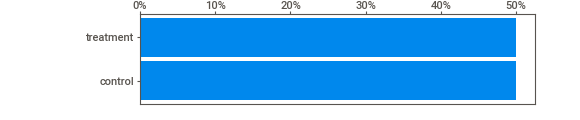
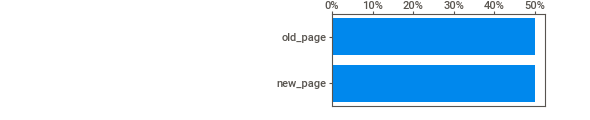
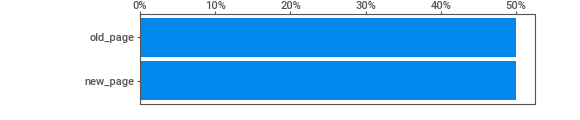
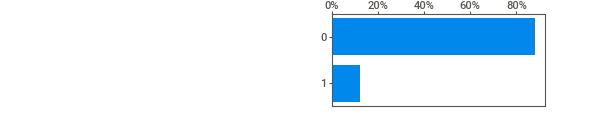
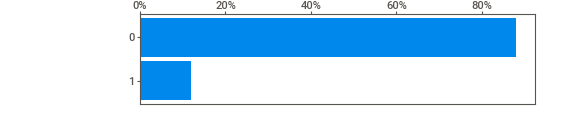
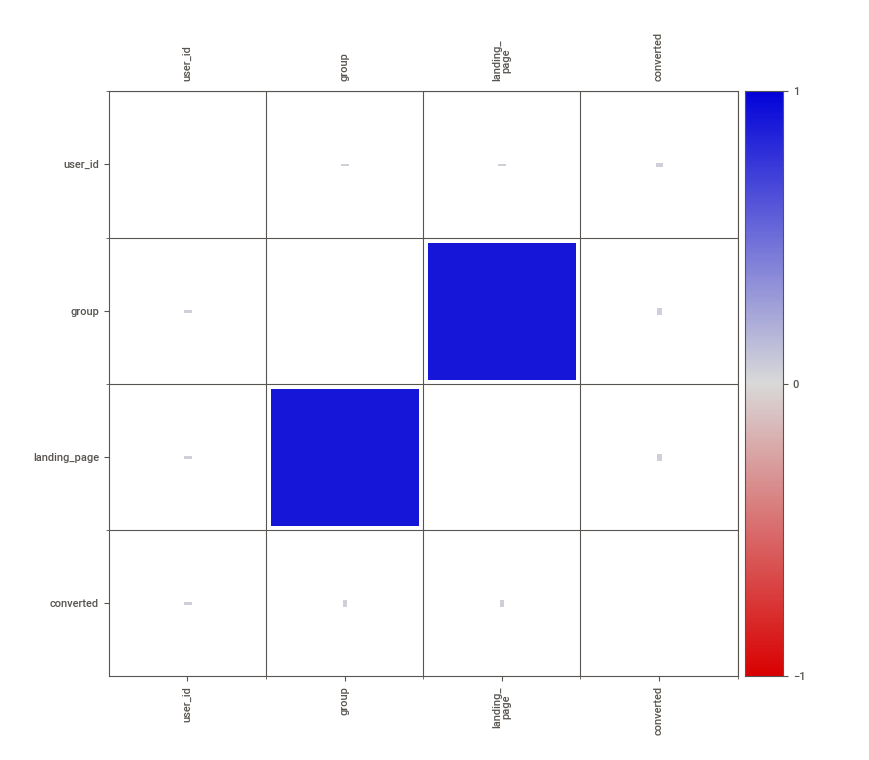
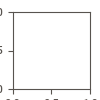

In [7]:
# create initial exploration reporting and show
report = sv.analyze(df)
report.show_notebook()

In [8]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


# Dropping users that are in both treatment and control

Some of the users occur in the dataset more than once. As we have 294478 rows and we need only 10268 of them, let's simply drop the doubles.

In [126]:
session_counts = df.user_id.value_counts()
double_users = session_counts[session_counts>1].index
print(f'{"Number of Users that are in both groups:".ljust(50)}{len(double_users)}')

print(f'{"Number of duplicate rows:".ljust(50)}{df.duplicated().sum()}')

Number of Users that are in both groups:          0
Number of duplicate rows:                         0


In [103]:
df = df[~df['user_id'].isin(double_users)]
df.shape

(286690, 5)

# Calculate Conversion Rates for Each Group

In [106]:
conversion_rates = df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


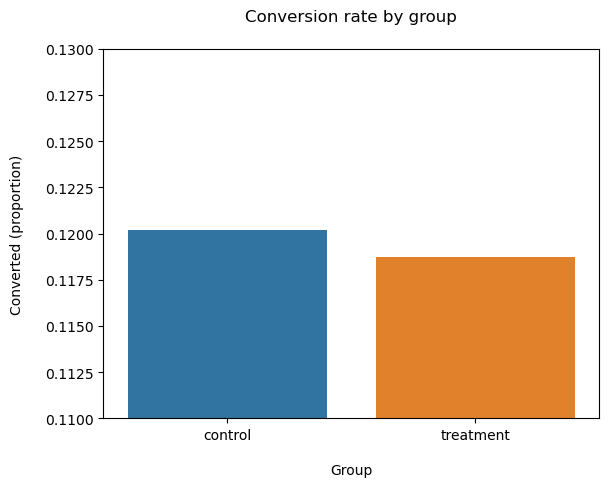

In [107]:
sns.barplot(x=df['group'], y=df['converted'], ci=False)

plt.ylim(0.11, 0.13)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

# Statistical Significance

In [110]:
control_conversion = df.query('group == "control"')['converted']
treatment_conversion = df.query('group == "treatment"')['converted']

print(f'Control Group Data Shape: \t{control_conversion.shape}\nTreatment Group Data Shape: \t{treatment_conversion.shape}')

Control Group Data Shape: 	(143293,)
Treatment Group Data Shape: 	(143397,)


In [111]:
nobs = [control_conversion.count(), treatment_conversion.count()]
successes = [control_conversion.sum(), treatment_conversion.sum()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

p-value: 0.232
95% Confidence interval for control group: [0.118, 0.122]
95% Confidence interval for treatment group: [0.117, 0.120]


## A more robust way of calculating pvalue and Confidencec Intervals

In [63]:
# Permutation Test Function 
def permutation_test_p_value(control, treatment, n_permutations=10000):
    np.random.seed(42)
    observed_diff = treatment.mean() - control.mean()
    perm_diffs = []

    # Combine both groups
    combined = np.concatenate([control, treatment])

    for _ in range(n_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined)

        # Split the shuffled data into new control and treatment groups
        new_control = combined[:len(control)]
        new_treatment = combined[len(control):]

        # Calculate the difference in means
        perm_diff = new_treatment.mean() - new_control.mean()
        perm_diffs.append(perm_diff)

    # Calculate p-value for two-tailed test
    p_value = 2 * min(
        np.mean(np.array(perm_diffs) <= observed_diff),
        np.mean(np.array(perm_diffs) >= observed_diff)
    )

    return p_value

# Bootstrapping Function 
def bootstrap_confidence_interval(control, treatment, n_bootstraps=10000):
    np.random.seed(42)  # For reproducibility
    boot_diffs = []

    for _ in range(n_bootstraps):
        # Resample with replacement
        control_sample = np.random.choice(control, size=len(control), replace=True)
        treatment_sample = np.random.choice(treatment, size=len(treatment), replace=True)

        # Calculate conversion rates
        control_rate = control_sample.mean()
        treatment_rate = treatment_sample.mean()

        # Store the difference in conversion rates
        boot_diffs.append(treatment_rate - control_rate)

    # Calculate 95% confidence interval
    lower_bound = np.percentile(boot_diffs, 2.5)
    upper_bound = np.percentile(boot_diffs, 97.5)

    return lower_bound, upper_bound

In [112]:
# Run Permutation Test for p-value
p_value = permutation_test_p_value(control_conversion, treatment_conversion)
print(f'Permutation Test p-value: {p_value:.3f}')

# Run Bootstrapping for Confidence Interval
ci_lower, ci_upper = bootstrap_confidence_interval(control_conversion, treatment_conversion)
print(f'Bootstrapping 95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]')

Permutation Test p-value: 0.224
Bootstrapping 95% Confidence Interval: [-0.004, 0.001]
